# IBM Data Science Certificate - Capstone Project

## Table of content:
* [1. Load data](#first-part)
* [2. Add geo coordinates](#second-part)
* [3. Clustering of cases locations](#third-part)
* [4. Exploration of venues located nearby buildings with cases](#fourth-part)

## 1. Load data <a class="anchor" id="first-part">

In [1]:
import numpy as np
import pandas as pd
import requests
import googlemaps
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors
import warnings

In [2]:
# read data from a csv file listing Hong Kong residential buildings in which probable/confirmed cases 
# have resided in the past 14 days or non-residential building with 2 or more probable/confirmed cases 
# in the past 14 days (English)  
# source : https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent
# URL : https://data.gov.hk/en-data/dataset/hk-dh-chpsebcddr-novel-infectious-agent/resource/d7403539-c52b-4895-864e-6a0b11c313b9
df = pd.read_csv('./data/building_list_eng.csv')
df

,District,Building name,Last date of residence of the case(s),Related probable/confirmed cases
0,Sai Kung,Yee Ching House Yee Ming Estate,NaN,"58,128"
1,Wan Chai,Envoy Garden,NaN,"114, 213"
2,Southern,"Block 28, Baguio Villa",NaN,Case notified by the health authority of Canad...
3,Tai Po,"Heng Tai House, Fu Heng Estate",NaN,"119, 124, 140"
4,Tuen Mun,"On Hei House, Siu Hei Court",NaN,"120, 121"
...,...,...,...,...
432,Central & Western,33 Des Voeux Road Central (non-residential),23/03/2020,402
433,Central & Western,Wah Po Building (non-residential),24/03/2020,319
434,Yau Tsim Mong,Silvercord (non-residential),24/03/2020,388
435,Sham Shui Po,Lander Hotel Prince Edward (non-residential),24/03/2020,388


## 2. Add geo coordinates
<a class="anchor" id="second-part">

In [3]:
# add Latitude and Logitude columns to the dataframe
df['Latitude']=np.nan
df['Longitude']=np.nan
gmaps = googlemaps.Client(key='XXXXXXXXXXXXXXXXXXXXXX')
for row in df.itertuples():
     address = df.at[row.Index, 'Building name']+', '+df.at[row.Index, 'District']+' District, '+'Hong Kong'
     geocode_result = gmaps.geocode(address)
     if ((len(geocode_result) > 0 )) and ('geometry' in geocode_result[0]) :
        df.at[row.Index, 'Latitude'] = geocode_result[0]['geometry']['location']['lat']
        df.at[row.Index, 'Longitude'] = geocode_result[0]['geometry']['location']['lng']


In [4]:
df

,District,Building name,Last date of residence of the case(s),Related probable/confirmed cases,Latitude,Longitude
0,Sai Kung,Yee Ching House Yee Ming Estate,NaN,"58,128",22.307034,114.263220
1,Wan Chai,Envoy Garden,NaN,"114, 213",22.264584,114.188604
2,Southern,"Block 28, Baguio Villa",NaN,Case notified by the health authority of Canad...,22.262689,114.131696
3,Tai Po,"Heng Tai House, Fu Heng Estate",NaN,"119, 124, 140",22.457911,114.170456
4,Tuen Mun,"On Hei House, Siu Hei Court",NaN,"120, 121",22.373186,113.967726
...,...,...,...,...,...,...
432,Central & Western,33 Des Voeux Road Central (non-residential),23/03/2020,402,22.283049,114.157233
433,Central & Western,Wah Po Building (non-residential),24/03/2020,319,22.283902,114.129211
434,Yau Tsim Mong,Silvercord (non-residential),24/03/2020,388,22.297496,114.169367
435,Sham Shui Po,Lander Hotel Prince Edward (non-residential),24/03/2020,388,22.326621,114.164267


In [5]:
# check places for which Latitudes and Longitudes have not been retrieved successfully
def nans(df): return df[df.isnull().any(axis=1)]
nans(df[['District','Building name','Latitude','Longitude']])

,District,Building name,Latitude,Longitude
258,Yau Tsim Mong,Grand Centre (non-residential),NaN,NaN
304,Yau Tsim Mong,23 Lock Road (non-residential),NaN,NaN
414,Eastern,Siu Sai Wan Plaza (non-residential),NaN,NaN


In [6]:
# Add missing latitude and longitude values (retrieved from google maps) :

# Yau Tsim Mong, Grand Centre (non-residential)
df.at[258, 'Latitude'] = 22.2990128
df.at[258, 'Longitude'] = 114.1724041
# Yau Tsim Mong, 23 Lock Road (non-residential)
df.at[304, 'Latitude'] = 22.2976185
df.at[304, 'Longitude'] = 114.1703024114
# Eastern, Siu Sai Wan Plaza
df.at[414, 'Latitude'] = 22.2627829
df.at[414, 'Longitude'] = 114.2468015

## 3. Clustering of cases locations <a class="anchor" id="third-part">

### 3.1 Checking for number of clusters

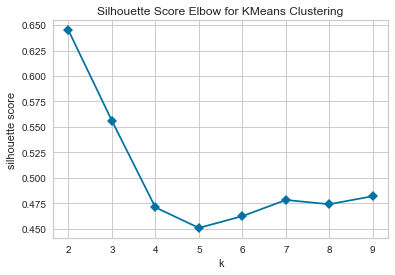

In [7]:
warnings.simplefilter('ignore')

# Instantiate a scikit-learn K-Means model
model = KMeans(random_state=0)

# Instantiate the KElbowVisualizer with the number of clusters and the metric 
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette', timings=False)

# Fit the data and visualize
visualizer.fit(df[['Latitude','Longitude']])    
visualizer.poof()   

### 3.2 Identify clusters with k-means

In [8]:
# set number of clusters
kclusters = 2
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df[['Latitude','Longitude']])

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

df.insert(6, 'Cluster Labels', kmeans.labels_)

In [9]:
df

,District,Building name,Last date of residence of the case(s),Related probable/confirmed cases,Latitude,Longitude,Cluster Labels
0,Sai Kung,Yee Ching House Yee Ming Estate,NaN,"58,128",22.307034,114.263220,0
1,Wan Chai,Envoy Garden,NaN,"114, 213",22.264584,114.188604,0
2,Southern,"Block 28, Baguio Villa",NaN,Case notified by the health authority of Canad...,22.262689,114.131696,0
3,Tai Po,"Heng Tai House, Fu Heng Estate",NaN,"119, 124, 140",22.457911,114.170456,0
4,Tuen Mun,"On Hei House, Siu Hei Court",NaN,"120, 121",22.373186,113.967726,1
...,...,...,...,...,...,...,...
432,Central & Western,33 Des Voeux Road Central (non-residential),23/03/2020,402,22.283049,114.157233,0
433,Central & Western,Wah Po Building (non-residential),24/03/2020,319,22.283902,114.129211,0
434,Yau Tsim Mong,Silvercord (non-residential),24/03/2020,388,22.297496,114.169367,0
435,Sham Shui Po,Lander Hotel Prince Edward (non-residential),24/03/2020,388,22.326621,114.164267,0


### 3.3 Visualisation of cases

In [10]:
hongkong_map = folium.Map(location=[22.3526632,113.9876166], zoom_start=11,tiles='Stamen Toner')
cluster_colors=['red','blue']
for lat, lon, building, cluster in zip(df['Latitude'], df['Longitude'],df['Building name'],df['Cluster Labels']):
    folium.CircleMarker([lat, lon],
                        radius=4,
                        color=cluster_colors[cluster],
                      popup =('Building: ' + str(building) + '<br>'),
                        fill_color=cluster_colors[cluster],
                        fill_opacity=0.7 ).add_to(hongkong_map)

hongkong_map

## 4. Exploration of venues located nearby buildings with cases <a class="anchor" id="fourth-part">

### 4.1 Venues located nearby buildings with cases

In [96]:
#Foursquare credentials
CLIENT_ID = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
CLIENT_SECRET = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX'
VERSION = '20200323' 
LIMIT = 50 

**Define a method to get venues nearby each building with cases:**

In [97]:
def getNearbyVenues(districts, buildings, latitudes, longitudes, radius=150):
    
    venues_list=[]
    for district, building, lat, lng in zip(districts, buildings, latitudes, longitudes):
        print(district+' district, '+building)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        response = requests.get(url).json()["response"]
        
        if(('groups' in response) and (len(response['groups']) > 0) and (len(response['groups'][0]['items']) > 0)) :
            results = response['groups'][0]['items']
        
            # return only relevant information for each nearby venue
            venues_list.append([(
                district,
                building, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])   
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    nearby_venues.columns = [
                  'District',
                  'Building', 
                  'Building Latitude', 
                  'building Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    return(nearby_venues)

**Apply this method to the data frame :** 

In [12]:
df_venues = getNearbyVenues(    districts=df['District'],
                                buildings=df['Building name'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude']
                            )


**Size of the resulting data frame :**

In [13]:
print(df_venues.shape)
df_venues.head()

(4212, 8)


,District,Building,Building Latitude,building Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wan Chai,Envoy Garden,22.264584,114.188604,Happy Valley (Upper) Bus Stop 跑馬地（上）巴士站,22.264392,114.188966,Bus Stop
1,Wan Chai,Envoy Garden,22.264584,114.188604,Yogo Happy Valley,22.264002,114.188833,Cupcake Shop
2,Wan Chai,Envoy Garden,22.264584,114.188604,Envoy Garden Bus Stop (安慧苑巴士站),22.264389,114.188804,Bus Stop
3,Southern,"Block 28, Baguio Villa",22.262689,114.131696,Baguio Villa (Lower) Minibus Stop 碧瑤灣（下）小巴站,22.261945,114.132117,Bus Stop
4,Southern,"Block 28, Baguio Villa",22.262689,114.131696,"The Arcade, Cyberport (數碼港商場)",22.263127,114.132820,Shopping Mall


**Number of buildings with cases nearby each venue :**

In [14]:
df_venues_count_building=df_venues.groupby(['Venue','Venue Latitude','Venue Longitude','Venue Category']).count()[['Building']].sort_values(by='Building', ascending=False)
df_venues_count_building[0:20]

,,,,Building
Venue,Venue Latitude,Venue Longitude,Venue Category,
Grill ขุนทอง,22.281279,114.155596,BBQ Joint,15
Le Boudoir,22.281470,114.154787,Cocktail Bar,15
Fringe Club Roof Garden,22.280302,114.155958,Bar,14
Porterhouse,22.281173,114.155580,Steakhouse,14
pherform,22.280430,114.156019,Gym,14
Hard Rock Café Hong Kong,22.280517,114.155297,American Restaurant,14
Tango Argentinian Steakhouse,22.281835,114.154728,Argentinian Restaurant,14
Flex Studio Central,22.280431,114.156020,Yoga Studio,14
Chrono,22.280819,114.155595,Karaoke Bar,14


**Most frequent venues categories**

In [15]:
df_venues_count_building.groupby('Venue Category').sum()[['Building']].sort_values(by='Building', ascending=False)[0:20]

,Building
Venue Category,
Coffee Shop,191
Chinese Restaurant,184
Café,167
Japanese Restaurant,155
Hotel,131
Italian Restaurant,108
Cantonese Restaurant,105
French Restaurant,100
Fast Food Restaurant,100


### 4.2 Visualisation of venues nearby buildings with  cases

In [16]:
df_main_venues=df_venues_count_building.query('Building>3').reset_index()
df_main_venues

,Venue,Venue Latitude,Venue Longitude,Venue Category,Building
0,Grill ขุนทอง,22.281279,114.155596,BBQ Joint,15
1,Le Boudoir,22.281470,114.154787,Cocktail Bar,15
2,Fringe Club Roof Garden,22.280302,114.155958,Bar,14
3,Porterhouse,22.281173,114.155580,Steakhouse,14
4,pherform,22.280430,114.156019,Gym,14
...,...,...,...,...,...
231,The Landmark (置地廣塲),22.281291,114.158158,Shopping Mall,4
232,Arirang Korean Restaurant (阿里郎韓國餐廳),22.297409,114.170488,Korean Restaurant,4
233,Urban Coffee Roaster,22.297400,114.172905,Coffee Shop,4
234,Le Garçon Saïgon,22.276796,114.168138,Vietnamese Restaurant,4


In [17]:
venues_map = folium.Map(location=[22.3526632,113.9876166], zoom_start=11,tiles='Stamen Toner')
colors_array = cm.YlOrRd(np.linspace(0, 1, 15))
colgrad = [colors.rgb2hex(i) for i in colors_array]
for lat, lon, venue, category, building in zip(df_main_venues['Venue Latitude'], df_main_venues['Venue Longitude'],
                                    df_main_venues['Venue'],df_main_venues['Venue Category'], df_main_venues['Building']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        color=colgrad[building-1],
                        popup =('Venue: ' + venue +'<br> Category : '+category+'<br> Nb.:'+str(building) + ' <br>'),
                        fill_color=colgrad[building-1],
                        fill_opacity=0.7 ).add_to(venues_map)

venues_map